# MNIST Gradient Descent NNs

## Load Data

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

np.set_printoptions(suppress=True)
np.seterr(divide = 'ignore') 

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

# normalisation
X_train = X_train / 255
X_test = X_test / 255

def createY(y):
    Y = np.zeros(10)
    Y[y] = 1
    return Y

# reshape
X_train = X_train.reshape(60000, 28 ** 2)
X_test = X_test.reshape(10000, 28 ** 2)
y_train = np.array([createY(y) for y in y_train])
y_test =np.array([createY(y) for y in y_test])

# tensorflow
X_train = tf.constant(X_train, dtype=tf.float64)
X_test = tf.constant(X_test, dtype=tf.float64)
y_train = tf.constant(y_train, dtype=tf.float64)
y_test = tf.constant(y_test, dtype=tf.float64)

## Initialize HyperParameters

In [2]:
def inistial_parameters(n, dims):
    
    W = {}
    B = {}
    
    for i in range(len(dims)):
        dim = dims[i]
        if i == 0:
            w =  np.random.randn(n, dim) * (np.sqrt(2 / dim))
            W['W' + str(i + 1)] = tf.constant(w)
            b = np.zeros((1, dim))
            B['b' + str(i + 1)] = tf.constant(b)
        else:
            w = np.random.randn(dims[i-1], dim) * (np.sqrt(2 / dim))
            W['W' + str(i + 1)] = tf.constant(w)
            b = np.zeros((1, dim))
            B['b' + str(i + 1)] = tf.constant(b)
            
    return {
        'W' : W,
        'b' : B
    }

## Linear Regression

In [3]:
def linear(X, W, b):
    return np.dot(X, W) + b

## ReLU

In [4]:
def relu(X):
    return np.maximum(X, 0)

## Softmax

In [5]:
def softmax(X):
    return (np.exp(X)) / (np.sum(np.exp(X)))

## Activation function

In [6]:
def activation(A_prev, W, b, active):
    """
    activation - sigmoid/relu/softmax
    """
    
    if active == 'sigmoid':
        Z = linear(A_prev, W, b)
        A = sigmoid(Z)
    elif active == 'relu':
        Z = linear(A_prev, W, b)
        A = relu(Z)
    elif active == 'softmax':
        Z = linear(A_prev, W, b)
        A = softmax(Z)
        
    return A, Z

## L model forward

In [7]:
def L_model_forward(X, W, b):
    A = X
    L = len(b)
    caches = {}
    
    caches['A0'] = A
    
    for i in range(1, L):
        A_prev = A
        
        A, Z = activation(A_prev, W['W' + str(i)], b['b' + str(i)], 'relu')
        caches['A' + str(i)] = A
        caches['Z' + str(i)] = Z
        
    AL, ZL = activation(A, W['W' + str(L)], b['b' + str(L)], 'softmax')
    caches['A' + str(L)] = AL
    caches['Z' + str(L)] = ZL
    
    return (AL, caches)

## CrossEntropy

In [42]:
def crossEntropy(haty, Y):
    m = haty.shape[0]

    ce = np.sum(np.sum(Y * np.log(haty), axis=1, keepdims=True)) 

    return - (1 / m) * ce 


## Train

In [39]:
def SGDRange(m, setpsize):
  sum = m
  setpsize = setpsize

  rangeArr = []

  for i in range(0, (sum // setpsize) * setpsize, setpsize):
    rangeArr.append([i, i + setpsize])
    
  if sum % setpsize != 0:
    lastone = sum // setpsize * setpsize
    rangeArr.append([lastone, lastone + sum % setpsize])
  return rangeArr

# debug
# rangeArr = SGDRange(124, 50)
# print(rangeArr)

In [61]:
n = X_train.shape[1]
alpha = 0.07

dims = [200, 200, 200, 10]
L = len(dims)

parameters = inistial_parameters(n, dims)
W = parameters['W']
b = parameters['b']

# AL, caches = L_model_forward(X_train, W, b)

cost_train = []
cost_test = []

def backpropagation(X, y):
    m = X.shape[0]

    with tf.GradientTape(persistent=True) as g:
        
        for i in range(1, L + 1):
            g.watch(W['W' + str(i)])
            g.watch(b['b' + str(i)])

        # ReLU
        A_previous = X
        for i in range(1, L):
            L_hidden = tf.experimental.numpy.dot(A_previous, W['W' + str(i)]) + b['b' + str(i)]
            A_previous = tf.math.maximum(L_hidden, 0) 

        # softmax
        LL = tf.experimental.numpy.dot(A_previous, W['W' + str(L)]) + b['b' + str(L)]
        AL = (tf.experimental.numpy.exp(LL)) / (tf.experimental.numpy.sum(tf.experimental.numpy.exp(LL))) 

        # cost function
        J = - tf.experimental.numpy.sum(y * tf.experimental.numpy.log(AL), axis=0, keepdims=True) / m

    cost_train.append(crossEntropy(AL, y))
        
    AL_test, _ = L_model_forward(X_test, W, b)
    m_test = AL_test.shape[0]
    cost_test.append(crossEntropy(AL_test, y_test))
    
    for i in range(1, L + 1):
        
        dJ_W = g.gradient(J, W['W' + str(i)])
        dJ_b = g.gradient(J, b['b' + str(i)])

        W['W' + str(i)] = W['W' + str(i)] - alpha * dJ_W
        b['b' + str(i)] = b['b' + str(i)] - alpha * dJ_b

for i in range(100):

  rangeArr = SGDRange(X_train.shape[0], 5000)
  for index in rangeArr:
    backpropagation(X_train[index[0]:index[1]], y_train[index[0]:index[1]])

  if i % 5 == 0:
    print('====enoch == {enoch}===='.format(enoch=i))
    print('cost_train: {cost_train}'.format(cost_train=cost_train[i]))
    print('cost_test: {cost_test}'.format(cost_test=cost_test[i]))


====enoch == 0====
cost_train: 15.405337837089972
cost_test: 16.30696030625204
====enoch == 5====
cost_train: 14.888755485411023
cost_test: 15.490418353471297
====enoch == 10====
cost_train: 10.606875065655247
cost_test: 11.28024630757684
====enoch == 15====
cost_train: 10.247911476725978
cost_test: 10.940515423931776
====enoch == 20====
cost_train: 10.016805354955682
cost_test: 10.683616089385747
====enoch == 25====
cost_train: 9.799310430001562
cost_test: 10.496304826510636
====enoch == 30====
cost_train: 9.71797008358089
cost_test: 10.36346205065664
====enoch == 35====
cost_train: 9.531161529790761
cost_test: 10.264744817868639
====enoch == 40====
cost_train: 9.506511864833964
cost_test: 10.188233164172114
====enoch == 45====
cost_train: 9.481231221768128
cost_test: 10.139654926948971
====enoch == 50====
cost_train: 9.431273767532852
cost_test: 10.085335403482508
====enoch == 55====
cost_train: 9.439125913623549
cost_test: 10.116195345983604
====enoch == 60====
cost_train: 9.3135961

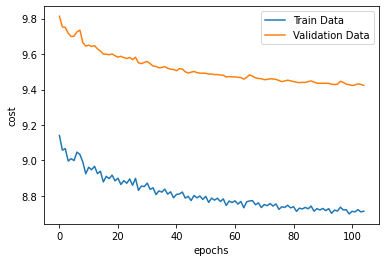

In [64]:
import matplotlib.pyplot as plt

plt.plot(cost_train[150::10], label="Train Data")
plt.plot(cost_test[150::10], label="Validation Data")
# print(np.max(current_percentage))
# plt.plot(current_percentage[:], label="Current Test")
plt.ylabel('cost')
plt.xlabel('epochs')
plt.legend()
plt.show()

## get correct percentage

In [65]:
def getCorrectPercentage(X, y):
  m = len(X)
  hatys, _ = L_model_forward(X, W, b)
  hatys = np.array([createY(np.argmax(y)) for y in hatys])
  corrent_num = np.sum(y * hatys)
  return corrent_num / m

print(getCorrectPercentage(X_train, y_train))
print(getCorrectPercentage(X_test, y_test))

0.9613166666666667
0.953


[[0.03290218 0.0016852  0.94197997 0.0110304  0.00000347 0.00481083
  0.00176303 0.00000762 0.00580702 0.00001028]]
2


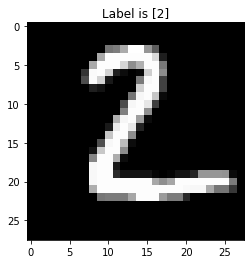

In [66]:
## Test
index = 1
single_label = np.where(y_test[index] == 1)[0]
single_Image = X_test[index].numpy()
single_Image_r = single_Image.reshape((28, 28))
test, _ = L_model_forward(single_Image, W, b)
print(test)
print(np.argmax(test))
plt.title('Label is {label}'.format(label=single_label))
plt.imshow(single_Image_r, cmap='gray')
plt.show()

In [87]:
test_data = pd.read_csv('test.csv')
test_data.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,...,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001357,0.012500,0.016786,0.031714,0.056000,0.100464,0.166929,...,3.272536,2.371464,1.454357,0.846286,0.509750,0.254750,0.062107,0.015250,0.000786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005429,0.024179,0.036250,0.083143,0.134107,0.201071,0.325000,0.366714,0.468143,0.589429,0.656964,0.569714,0.464214,0.323679,0.164607,0.073214,0.028036,0.011250,0.006536,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.227093,1.566275,1.513515,2.674449,3.216234,4.549478,5.470524,...,25.211706,21.240003,16.643468,12.637953,9.963879,7.031504,3.040514,1.265562,0.131475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.640468,2.234963,2.493982,3.777711,4.946940,6.262819,7.714814,8.243535,8.974038,10.488695,11.209508,10.204173,9.402197,7.878854,5.473293,3.616811,1.813602,1.205211,0.807475,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [88]:
hatys = []
for single_Image in test_data.values:
    haty, _ = L_model_forward(single_Image, W, b)
    hatys.append(np.argmax(haty))
    
hatys = pd.DataFrame(zip(range(1, len(hatys) + 1), hatys), columns=['ImageId', 'Label'])

In [89]:
len(hatys)

28000

In [90]:
hatys.to_csv('submission.csv', index=False)